# 05 - Hyperparameter Tuning

This notebook performs hyperparameter optimization for the best performing models:
- Grid Search CV
- Randomized Search CV
- Focus on XGBoost, LightGBM, and Random Forest
- Final model selection and saving

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Data and Previous Results

In [2]:
# Load engineered features
df = pd.read_csv('../processed_data/steel_data_featured.csv')

# Load previous results to identify best model
results_df = pd.read_csv('../models/model_comparison.csv', index_col=0)

print(f"Dataset shape: {df.shape}")
print(f"\nPrevious model performance:")
print(results_df.sort_values('R2', ascending=False))

Dataset shape: (35040, 79)

Previous model performance:
                       RMSE       MAE        R2  MAPE
Linear Regression  0.000126  0.000109  1.000000   inf
Ridge Regression   0.149412  0.106806  0.999977   inf
Gradient Boosting  1.053814  0.550096  0.998872   inf
XGBoost            1.147202  0.638704  0.998663   inf
Random Forest      1.230445  0.572386  0.998462   inf
LightGBM           1.418085  0.857658  0.997957   inf
Decision Tree      1.679492  0.692999  0.997134   inf
Lasso Regression   2.627982  1.635925  0.992983   inf
Neural Network     4.373670  2.614180  0.980564   inf


## Prepare Data

In [3]:
# Define target and features
target = 'Usage_kWh'
exclude_cols = [target, 'date', 'Day_of_week']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df[target]

# Chronological split for time series
split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (28032, 76)
Test set: (7008, 76)


## Define Evaluation Function

In [4]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate model performance
    """
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    print(f"\n{model_name} Performance:")
    print("="*60)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape, 'predictions': y_pred}

# Store tuned model results
tuned_results = {}

print("Evaluation function ready!")

Evaluation function ready!


## 1. XGBoost Hyperparameter Tuning

In [5]:
print("XGBoost Hyperparameter Tuning...\n")

# Define parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5]
}

# Use RandomizedSearchCV for efficiency
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

xgb_random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=3,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

xgb_random.fit(X_train, y_train)

print(f"\nBest parameters: {xgb_random.best_params_}")
print(f"Best CV score: {xgb_random.best_score_:.4f}")

XGBoost Hyperparameter Tuning...

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Best CV score: 0.9947


In [6]:
# Evaluate tuned XGBoost
best_xgb = xgb_random.best_estimator_
tuned_results['XGBoost_Tuned'] = evaluate_model(best_xgb, X_test, y_test, 'XGBoost (Tuned)')

# Save model
joblib.dump(best_xgb, '../models/xgboost_tuned.pkl')
print("\nTuned XGBoost model saved!")


XGBoost (Tuned) Performance:
RMSE: 1.0145
MAE: 0.5597
R² Score: 0.9990
MAPE: inf%

Tuned XGBoost model saved!


## 2. LightGBM Hyperparameter Tuning

In [7]:
print("LightGBM Hyperparameter Tuning...\n")

# Define parameter grid
lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_samples': [10, 20, 30]
}

lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)

lgb_random = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_param_grid,
    n_iter=20,
    cv=3,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

lgb_random.fit(X_train, y_train)

print(f"\nBest parameters: {lgb_random.best_params_}")
print(f"Best CV score: {lgb_random.best_score_:.4f}")

LightGBM Hyperparameter Tuning...

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'subsample': 0.7, 'num_leaves': 31, 'n_estimators': 300, 'min_child_samples': 10, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best CV score: 0.9940


In [8]:
# Evaluate tuned LightGBM
best_lgb = lgb_random.best_estimator_
tuned_results['LightGBM_Tuned'] = evaluate_model(best_lgb, X_test, y_test, 'LightGBM (Tuned)')

# Save model
joblib.dump(best_lgb, '../models/lightgbm_tuned.pkl')
print("\nTuned LightGBM model saved!")


LightGBM (Tuned) Performance:
RMSE: 1.1764
MAE: 0.6929
R² Score: 0.9986
MAPE: inf%

Tuned LightGBM model saved!


## 3. Random Forest Hyperparameter Tuning

In [9]:
print("Random Forest Hyperparameter Tuning...\n")

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=15,
    cv=3,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

print(f"\nBest parameters: {rf_random.best_params_}")
print(f"Best CV score: {rf_random.best_score_:.4f}")

Random Forest Hyperparameter Tuning...

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Best CV score: 0.9917


In [10]:
# Evaluate tuned Random Forest
best_rf = rf_random.best_estimator_
tuned_results['RandomForest_Tuned'] = evaluate_model(best_rf, X_test, y_test, 'Random Forest (Tuned)')

# Save model
joblib.dump(best_rf, '../models/random_forest_tuned.pkl')
print("\nTuned Random Forest model saved!")


Random Forest (Tuned) Performance:
RMSE: 1.9078
MAE: 1.0074
R² Score: 0.9963
MAPE: inf%

Tuned Random Forest model saved!


## Compare Tuned Models

In [11]:
# Create comparison dataframe
tuned_results_df = pd.DataFrame({
    model: {k: v for k, v in metrics.items() if k != 'predictions'}
    for model, metrics in tuned_results.items()
}).T

tuned_results_df = tuned_results_df.sort_values('R2', ascending=False)

print("\n" + "="*80)
print("TUNED MODELS COMPARISON")
print("="*80)
print(tuned_results_df)

# Save results
tuned_results_df.to_csv('../models/tuned_models_comparison.csv')
print("\nResults saved to: ../models/tuned_models_comparison.csv")


TUNED MODELS COMPARISON
                        RMSE       MAE        R2  MAPE
XGBoost_Tuned       1.014532  0.559715  0.998954   inf
LightGBM_Tuned      1.176390  0.692903  0.998594   inf
RandomForest_Tuned  1.907840  1.007403  0.996302   inf

Results saved to: ../models/tuned_models_comparison.csv


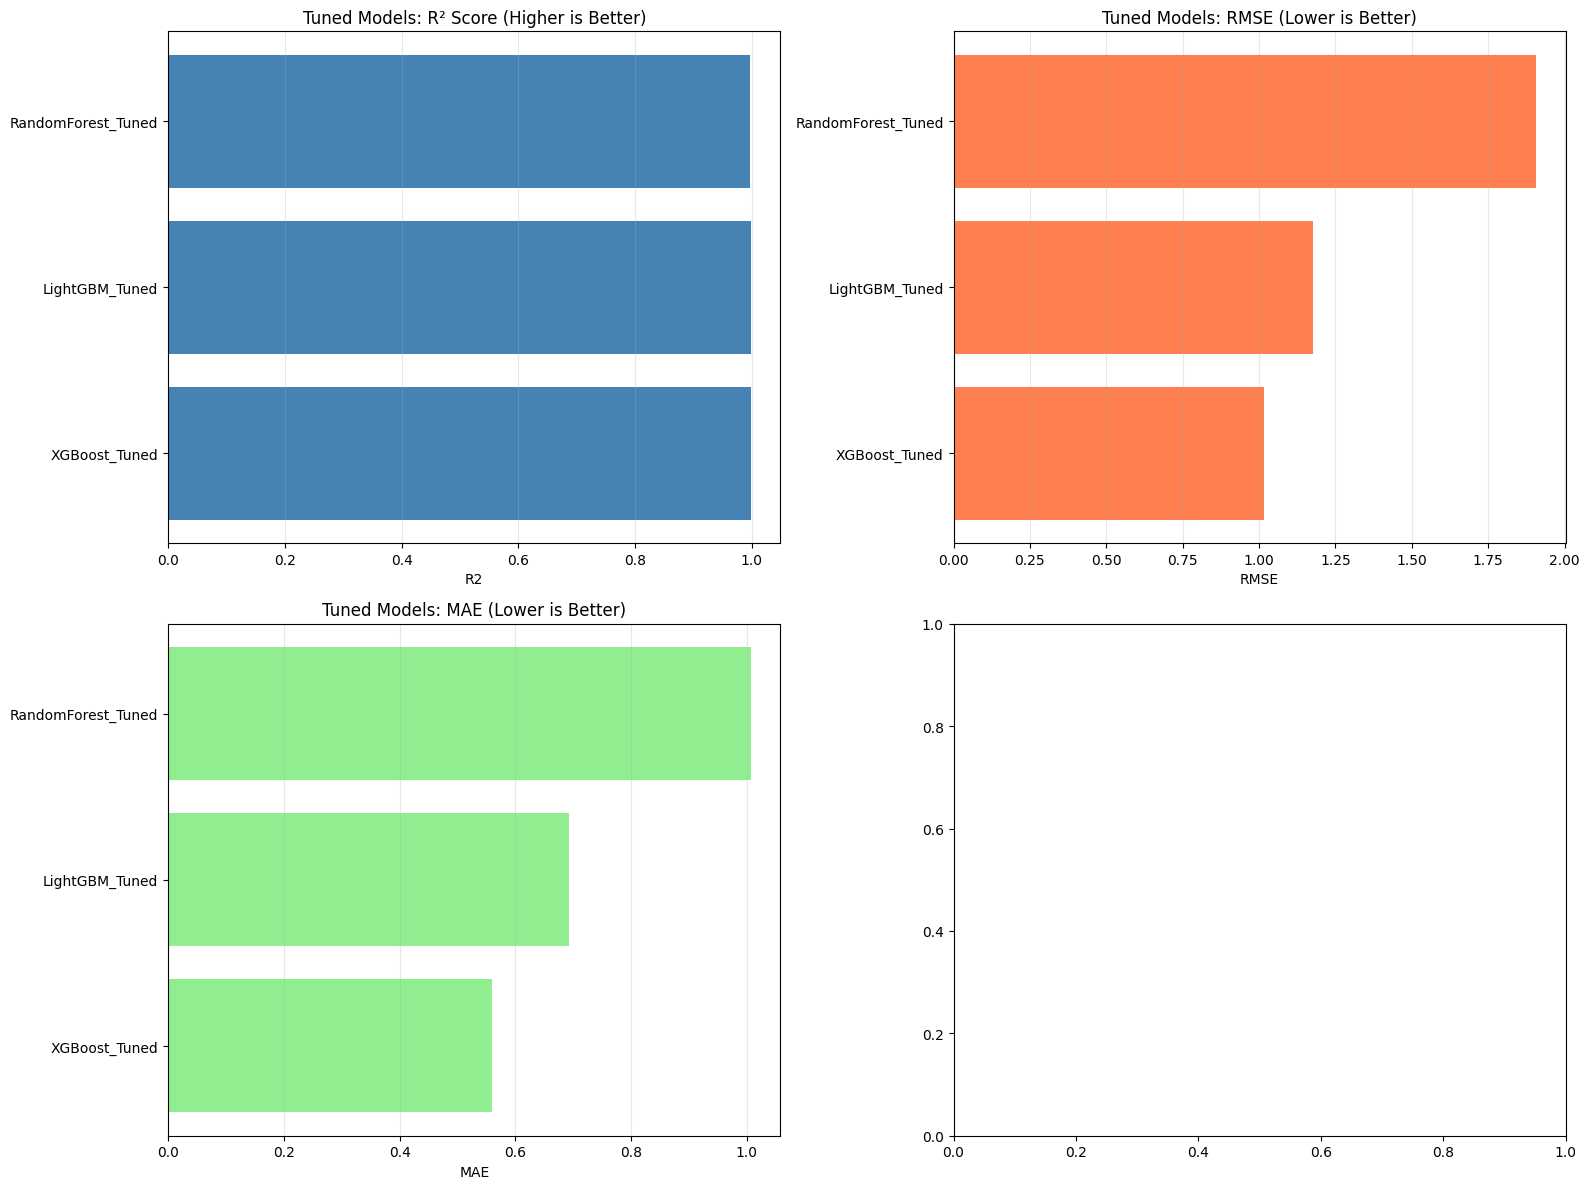

Comparison plot saved!


In [17]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['R2', 'RMSE', 'MAE', 'MAPE']
colors = ['steelblue', 'coral', 'lightgreen', 'gold']
titles = [
    'R² Score (Higher is Better)',
    'RMSE (Lower is Better)',
    'MAE (Lower is Better)'
]

for idx, (metric, color, title) in enumerate(zip(metrics, colors, titles)):
    ax = axes[idx // 2, idx % 2]
    ax.barh(tuned_results_df.index, tuned_results_df[metric], color=color)
    ax.set_xlabel(metric)
    ax.set_title(f'Tuned Models: {title}')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../models/tuned_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comparison plot saved!")

## Select Final Best Model

In [18]:
# Identify best model
best_model_name = tuned_results_df.index[0]
best_r2 = tuned_results_df.loc[best_model_name, 'R2']

print(f"\n{'='*80}")
print("FINAL BEST MODEL")
print(f"{'='*80}")
print(f"Model: {best_model_name}")
print(f"R² Score: {best_r2:.4f}")
print(f"\nFull metrics:")
print(tuned_results_df.loc[best_model_name])

# Select the best model object
if 'XGBoost' in best_model_name:
    final_model = best_xgb
    model_path = '../models/xgboost_tuned.pkl'
elif 'LightGBM' in best_model_name:
    final_model = best_lgb
    model_path = '../models/lightgbm_tuned.pkl'
else:
    final_model = best_rf
    model_path = '../models/random_forest_tuned.pkl'

# Save as final model
joblib.dump(final_model, '../models/final_model.pkl')
print(f"\nFinal model saved to: ../models/final_model.pkl")


FINAL BEST MODEL
Model: XGBoost_Tuned
R² Score: 0.9990

Full metrics:
RMSE    1.014532
MAE     0.559715
R2      0.998954
MAPE         inf
Name: XGBoost_Tuned, dtype: float64

Final model saved to: ../models/final_model.pkl


## Final Model Analysis

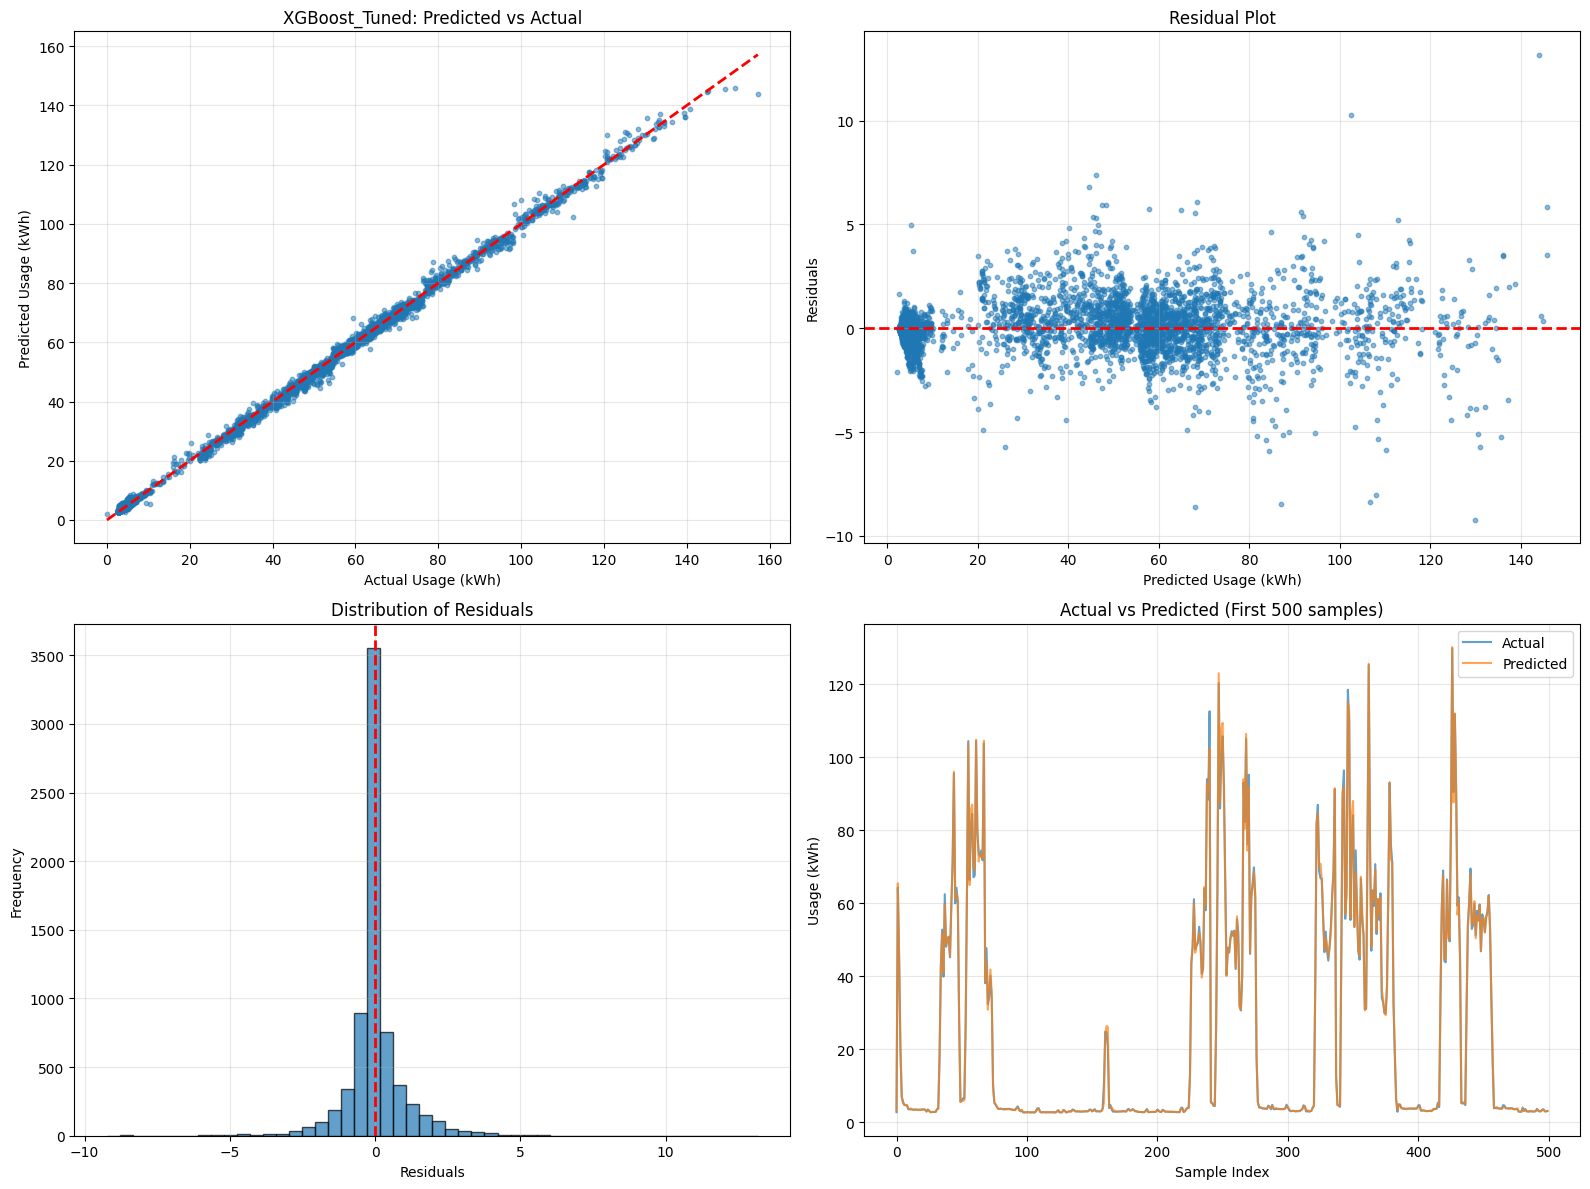

Final model analysis plot saved!


In [19]:
# Get predictions from final model
y_pred_final = final_model.predict(X_test)

# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Predicted vs Actual
axes[0, 0].scatter(y_test, y_pred_final, alpha=0.5, s=10)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Usage (kWh)')
axes[0, 0].set_ylabel('Predicted Usage (kWh)')
axes[0, 0].set_title(f'{best_model_name}: Predicted vs Actual')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residual plot
residuals = y_test.values - y_pred_final
axes[0, 1].scatter(y_pred_final, residuals, alpha=0.5, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Usage (kWh)')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residual distribution
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].grid(True, alpha=0.3)

# 4. Time series plot (first 500 predictions)
plot_range = min(500, len(y_test))
axes[1, 1].plot(range(plot_range), y_test.values[:plot_range], label='Actual', alpha=0.7)
axes[1, 1].plot(range(plot_range), y_pred_final[:plot_range], label='Predicted', alpha=0.7)
axes[1, 1].set_xlabel('Sample Index')
axes[1, 1].set_ylabel('Usage (kWh)')
axes[1, 1].set_title('Actual vs Predicted (First 500 samples)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/final_model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Final model analysis plot saved!")

## Feature Importance (if applicable)


Top 20 Most Important Features:
                                 feature  importance
2                              CO2(tCO2)    0.616411
22                           usage_lag_1    0.120576
0   Lagging_Current_Reactive.Power_kVarh    0.105443
38                  usage_rolling_mean_4    0.049992
4           Leading_Current_Power_Factor    0.029819
54                  total_reactive_power    0.011890
56                      avg_power_factor    0.010027
41                   usage_rolling_max_4    0.009475
45                   usage_rolling_max_8    0.008865
57                  reactive_power_ratio    0.007852
40                   usage_rolling_min_4    0.007488
39                   usage_rolling_std_4    0.004824
15                              hour_cos    0.003839
55                     power_factor_diff    0.002844
44                   usage_rolling_min_8    0.001180
3           Lagging_Current_Power_Factor    0.001160
12                            weekofyear    0.000987
62           

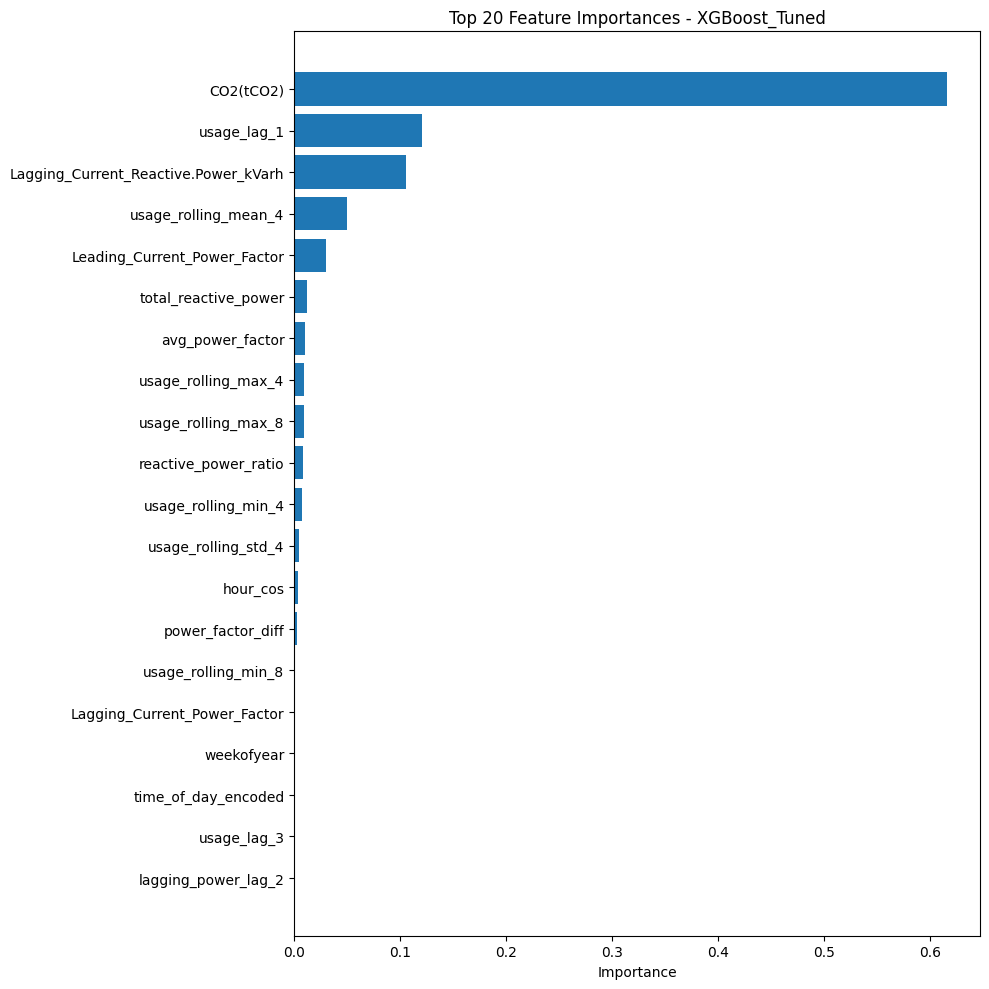


Feature importance saved!


In [20]:
# Get feature importance
if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 20 Most Important Features:")
    print(feature_importance.head(20))
    
    # Plot
    plt.figure(figsize=(10, 10))
    plt.barh(range(20), feature_importance['importance'].head(20))
    plt.yticks(range(20), feature_importance['feature'].head(20))
    plt.xlabel('Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('../models/final_model_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save feature importance
    feature_importance.to_csv('../models/feature_importance.csv', index=False)
    print("\nFeature importance saved!")
else:
    print("\nModel does not have feature_importances_ attribute")

## Save Model Metadata

In [21]:
# Save model information
model_info = {
    'model_name': best_model_name,
    'model_type': type(final_model).__name__,
    'r2_score': float(best_r2),
    'rmse': float(tuned_results_df.loc[best_model_name, 'RMSE']),
    'mae': float(tuned_results_df.loc[best_model_name, 'MAE']),
    'mape': float(tuned_results_df.loc[best_model_name, 'MAPE']),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'n_features': len(feature_cols),
    'feature_names': feature_cols
}

import json
with open('../models/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("Model metadata saved to: ../models/model_info.json")
print("\n" + "="*80)
print("HYPERPARAMETER TUNING COMPLETE!")
print("="*80)

Model metadata saved to: ../models/model_info.json

HYPERPARAMETER TUNING COMPLETE!


## Summary

Hyperparameter tuning completed successfully:
- XGBoost, LightGBM, and Random Forest models tuned
- Best model identified and saved
- Comprehensive evaluation performed
- Model ready for deployment

Next step: Use the prediction script to make predictions on new data.